# Translation with a Sequence to Sequence Network and Attention

Source
http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

---
## Prep

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

# use_cuda = torch.cuda.is_available()

In [3]:
SOS_token = 1
EOS_token = 1

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
        
    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)
            
    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def unicode_to_ascii(s):
    # Turn a Unicode string to plain ASCII
    # http://stackoverflow.com/a/518232/2809427
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [6]:
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
# some data restrictions
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [9]:
def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

In [10]:
def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [11]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['c est ma camarade de classe .', 'she s my classmate .']


---
## Seq2Seq Model
2 RNNs = encoder + decoder
context = last encoder output -> initial hidden state of decoder

![encoder](assets/encoder-network.png)
![decoder](assets/decoder-network.png)

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        # if use_cuda: return result.cuda()
        return result

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        # if use_cuda: return result.cuda()
        return result

![attention](assets/1152PYf.png) 

![decoder](assets/attention-decoder-network.png)

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def init_hidden(self):
        result = Variable(torch.zero(1, 1, self.hidden_size))
        # if use_conda: return result.cuda()
        return result

attention here is relative to absolute positions, see **local attention**  for a relative position approach that works around the length limitation

---

## Data Prep

In [16]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [17]:
def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    # if use_cuda: return result.cuda()
    return result

In [18]:
def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

---

## Training

**teacher forcing** = using the real target outputs as each next input (instead of decoder's guess) -> faster convergence, unstable predictions

In [19]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    # encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_inputs
    
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
        
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    # decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # feed target as next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                        decoder_hidden,
                                                                        encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # here's the magic!
        
    else:
        # use decoder prediction as next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                        decoder_hidden,
                                                                        encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            # decoder_input = decoder_input.cuda if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[di])
            if ni ++ EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [20]:
from time import time
from math import floor

def as_minutes(s):
    m = floor(s)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [21]:
def train_iters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0 # reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    
    training_pairs = [variables_from_pair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, 1+n_iters):
        training_pair = training_pairs[iter-1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        
        loss = train(input_variable, target_variable, encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    show_plot(plot_losses)

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

---

## Evaluation

In [28]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    # encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]
    
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    # decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                    decoder_hidden, 
                                                                    encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        # decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        
    return decoded_words, decoder_attentions[:di+1]   

In [29]:
def evaluate_randomly(encoder, decoder, n = 10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

---

## Run

247m -14572s (- 247m -14572s) (5000 50%) 1.5285
510m -30089s (- 0m 0s) (10000 100%) 1.1397


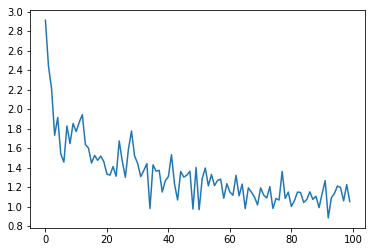

In [25]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)

# if use_cuda:
#     encoder1 = encoder1.cuda()
#     attn_decoder1 = attn_decoder1.cuda()

train_iters(encoder1, attn_decoder1, 10000, print_every=5000)

In [30]:
evaluate_randomly(encoder1, attn_decoder1)

> je suis impatiente de la prochaine fois .
= i m looking forward to the next time .
< i m going to be here . <EOS>

> elle lui est apparentee .
= she is related to him .
< she is very busy . <EOS>

> je ne suis pas normal .
= i m not normal .
< i m not sure . <EOS>

> elle est entierement devouee a ses trois enfants .
= she is devoted to her three children .
< she is a good man . <EOS>

> je suis content de mon travail .
= i m satisfied with my work .
< i m going to be a friend . <EOS>

> je suis allongee dans l herbe .
= i m lying on the grass .
< i m in a lot . <EOS>

> elles sont tres compatibles .
= they are very compatible .
< they re very busy . <EOS>

> je suis benie .
= i m blessed .
< i m a lot . <EOS>

> nous avons fini .
= we re finished .
< we re all tired . <EOS>

> tu es tres ouverte .
= you re very open .
< you re very astute . <EOS>



---

## Visualization
attention mechanism -> highly interpretable outputs -> look where net is focused at each time step

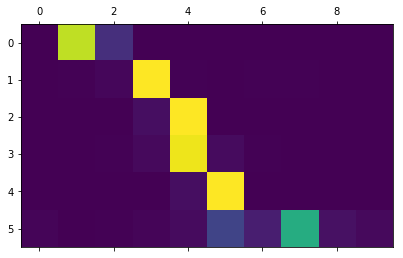

In [31]:
#simple
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [36]:
# better
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [37]:
def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she is very busy . <EOS>


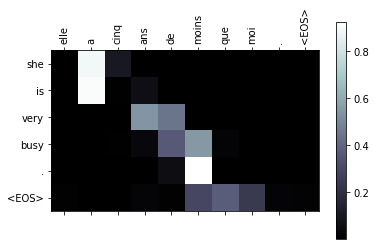

In [38]:
evaluate_and_show_attention('elle a cinq ans de moins que moi .')

input = elle est trop petit .
output = she is very busy . <EOS>


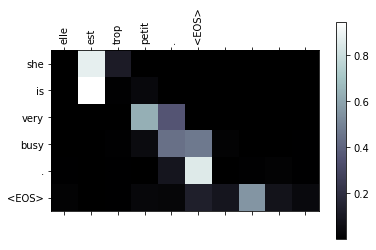

In [39]:
evaluate_and_show_attention('elle est trop petit .')

input = je ne crains pas de mourir .
output = i m not a friend . <EOS>


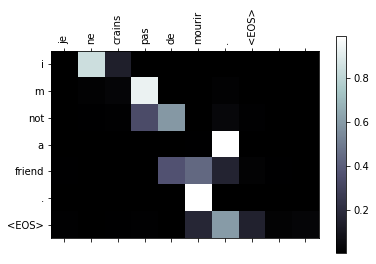

In [40]:
evaluate_and_show_attention('je ne crains pas de mourir .')

input = c est un jeune directeur plein de talent .
output = he is a good man . <EOS>


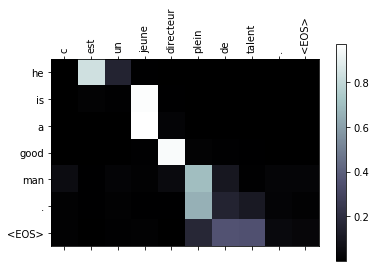

In [41]:
evaluate_and_show_attention('c est un jeune directeur plein de talent .')

---
## Going Further
+ change dataset
    + different language pair
    + chat -> reply
    + question -> answer
+ use pre-trained embeddings (word2vec, glove, ..)
+ add layers, hidden units, sentences
+ input=output -> autoencoder, only save encoder, train new decoder for translation
